In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

from os import listdir
from os.path import join
from scipy.io import wavfile

import IPython.display as ipd

import librosa
from librosa import feature as ft
from librosa import effects as et
from librosa import display as disp

from scipy import stats as st 

from scipy import signal as sg

In [2]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn import svm
from sklearn import neighbors

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ParameterGrid

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import sklearn

In [3]:
rs = 42

## Functions

In [4]:
def normalize_dataset(X):
    return [st.zscore(x) for x in X]

In [5]:
#Denoising each signal with a  filter

def denoising_dataset(X):
    return [sg.savgol_filter(x, window_length = 15, polyorder = 5) for x in X]
    #return [sg.wiener(x) for x in X]

In [6]:
#Trim leading and trailing silence from an audio signal

def remove_silence(X):
    yt = []
    for y in X:
        ytr, _ = et.trim(y, top_db = 35, frame_length = 256, hop_length = 64)
        yt.append(ytr)
    return yt

In [7]:
#Trimming and zero-padding the dataset 

def compute_length(X):
    return [len(x) for x in X]

def compute_percentile(X_length, perc = 95):
    length_percentile = int(np.ceil(np.percentile(X_length, perc)))
    return length_percentile
    
def equal_length(X, length_percentile):
    X = [x[:length_percentile] for x in X]
    X = [np.pad(x, (0, length_percentile - len(x)), constant_values = 0.0) for x in X]
    return X

In [8]:
def compute_mfcc(x):
    mfcc = ft.mfcc(y = x, sr = SR, n_mfcc = 13, n_fft = 512)
    mfcc = (mfcc - np.mean(mfcc, axis = 1).reshape(-1,1))/(np.std(mfcc, axis = 1).reshape(-1,1))
    return (np.hstack(mfcc))

def compute_mfcc_delta(x):
    mfcc = ft.mfcc(y = x, sr = SR, n_mfcc = 13, n_fft = 512)
    mfcc_delta = ft.delta(mfcc)
    mfcc = (mfcc - np.mean(mfcc, axis = 1).reshape(-1,1))/(np.std(mfcc, axis = 1).reshape(-1,1))
    x_sp = np.concatenate((mfcc, mfcc_delta))
    return (np.hstack(x_sp))    

def compute_mfcc_delta_delta(x):
    mfcc = ft.mfcc(y = x, sr = SR, n_mfcc = 13, n_fft = 512)
    mfcc_delta = ft.delta(mfcc)
    mfcc_delta_delta = ft.delta(mfcc, order = 2)
    mfcc = (mfcc - np.mean(mfcc, axis = 1).reshape(-1,1))/(np.std(mfcc, axis = 1).reshape(-1,1))
    x_sp = np.concatenate((mfcc, mfcc_delta))    
    x_sp = np.concatenate((x_sp, mfcc_delta_delta))
    return (np.hstack(x_sp))

def compute_dataset_features(X, method = 'mfcc'):
    if method == 'mfcc':
        X_sp = [compute_mfcc(x) for x in X]
    if method == "mfcc_delta":
        X_sp = [compute_mfcc_delta(x) for x in X]
    if method == "mfcc_delta_delta":
        X_sp = [compute_mfcc_delta_delta(x) for x in X]
    return np.vstack(X_sp) 

## Loading the dataset

In [9]:
df = pd.read_csv('development.csv', sep = ',', low_memory = False)

In [10]:
df["intent"] = df["action"] + df["object"]
gender = df["gender"]
df.drop(["Id", "speakerId", "Self-reported fluency level ", "First Language spoken", "Current language used for work/school", "gender", "ageRange"], axis = 1, inplace = True)
df.drop(["object", "action"], axis = 1, inplace = True)
dirs = df['path']

## Preprocessing

Resample and shifting

In [11]:
SR = 22050

In [12]:
file_p = []

for audio, g in zip(dirs, gender):
    data,_ = librosa.load(audio)
    if g == "female":
        data = et.pitch_shift(data, sr = SR, n_steps = -1, bins_per_octave = 12)
    file_p.append(data)

In [13]:
dev_y = df['intent']

Normalizing

In [14]:
dev_X = normalize_dataset(file_p)

Denoising

In [15]:
dev_X = denoising_dataset(dev_X)

Removing silence

In [16]:
dev_X = remove_silence(dev_X)

Padding and trimming

In [17]:
X_length = compute_length(dev_X)

In [18]:
perc = compute_percentile(X_length, perc = 95)

In [19]:
dev_X = equal_length(dev_X, perc)

Extracting features

In [20]:
X_sp = compute_dataset_features(dev_X, method = 'mfcc')

In [21]:
X_sp_delta = compute_dataset_features(dev_X, method = 'mfcc_delta')

In [22]:
X_sp_delta_delta = compute_dataset_features(dev_X, method = 'mfcc_delta_delta')

## Graphics

Show the first audio without pitch shifting, with pitch shifting and with denoising and silence removed.

In [59]:
audio_0,_ = librosa.load(dirs[0])
audio_0_shifted = et.pitch_shift(audio_0, sr = SR, n_steps = -1, bins_per_octave = 12)
audio_0_preproc = sg.savgol_filter(audio_0_shifted, window_length = 15, polyorder = 5)
audio_0_preproc, _ = et.trim(audio_0_preproc, top_db = 35, frame_length = 256, hop_length = 64)

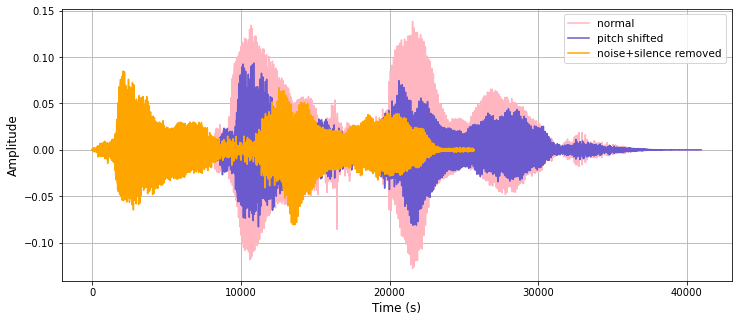

In [60]:
fig, ax = plt.subplots(1, 1, figsize = (12, 5))
ax.plot(audio_0, label = "normal", color = "lightpink")
ax.plot(audio_0_shifted, label = "pitch shifted", color = "slateblue")
ax.plot(audio_0_preproc, label = "noise+silence removed", color = "orange")
#ax.set_xticks(np.arange(0, len(audio_0), 10))
#ax.set_xticklabels([sample/SR for sample in np.arange(0, len(audio_0), 10)])
ax.set_ylabel("Amplitude", fontsize = 12)
ax.set_xlabel("Time (s)", fontsize = 12)
leg = ax.legend(prop = {'size': 10.5})
plt.grid(True)
plt.show()

Histogram of lengths

In [23]:
X = normalize_dataset(file_p)

In [24]:
X = denoising_dataset(dev_X)

In [25]:
X = remove_silence(dev_X)

In [26]:
Length = compute_length(X)
perc_95 = compute_percentile(Length, perc = 95)

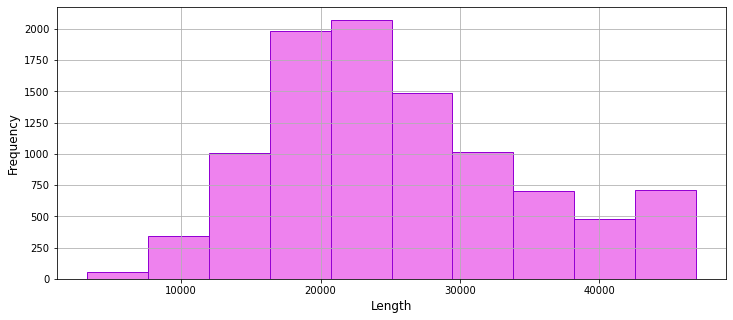

In [61]:
fig, ax = plt.subplots(1, 1, figsize = (12, 5))
plt.hist(Length, facecolor = 'violet', edgecolor = 'darkviolet', linewidth = 1)
ax.set_ylabel("Frequency", fontsize = 12)
ax.set_xlabel("Length", fontsize = 12)
#plt.axvline(perc_95, color='orange')
plt.grid(True)
plt.show()

MFCC plot

In [27]:
X_after = equal_length(X, perc_95)

In [28]:
mfcc0 = ft.mfcc(y = X_after[0], sr = SR, n_mfcc = 13, n_fft = 512)
mfcc0_MV = (mfcc0 - np.mean(mfcc0, axis = 1).reshape(-1,1))/(np.std(mfcc0, axis = 1).reshape(-1,1))

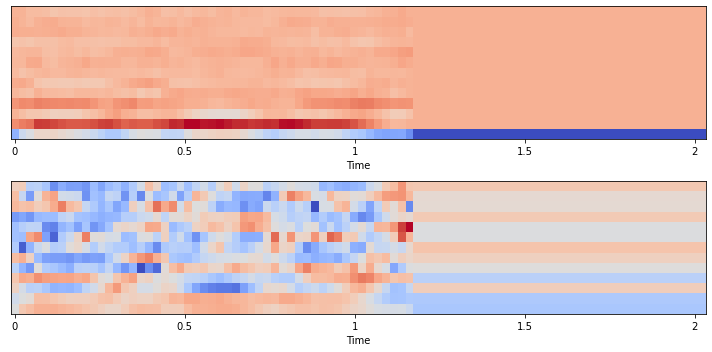

In [29]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (10, 5))
librosa.display.specshow(mfcc0, sr = SR, x_axis = 'time', ax = ax[0])
librosa.display.specshow(mfcc0_MV, sr = SR, x_axis = 'time', ax = ax[1]) 
fig.tight_layout()
plt.show()

class

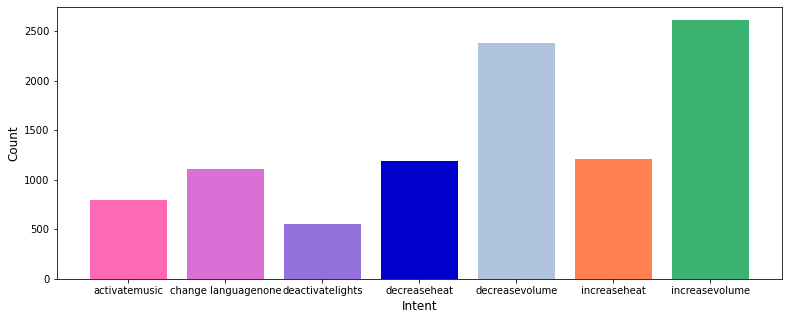

In [62]:
class_, counts_ = np.unique(np.array(dev_y), return_counts = True)
fig, ax = plt.subplots(1, 1, figsize = (13, 5))
plt.bar(class_, counts_, color = ['hotpink', 'orchid', 'mediumpurple', 'mediumblue', 'lightsteelblue', 'coral', 'mediumseagreen'])
ax.set_ylabel("Count", fontsize = 12)
ax.set_xlabel("Intent", fontsize = 12)
#plt.axvline(perc_95, color='orange')
#plt.grid(True)
plt.show()

## Hyperparameters tuning

We split the dataset Trainig, Validition and Test set as 60 20 20

In [30]:
x_train, x_val_test, y_train, y_val_test = train_test_split(X_sp, dev_y, test_size = 0.40, random_state = rs, stratify = dev_y)

x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size = 0.20, random_state = rs, stratify = y_val_test)

x_train_final = np.concatenate((x_train, x_val))
y_train_final = np.concatenate((y_train, y_val))

# MFCC

### SVM

In [31]:
minmax_s = MinMaxScaler()
minmax_s.fit(x_train)
x_train_norm = minmax_s.transform(x_train)
x_val_norm = minmax_s.transform(x_val)

param_grid = {'C': [1, 5, 7, 10],
              'kernel': ['rbf', 'poly', 'linear']}

accuracies = []
for config in ParameterGrid(param_grid):
    supportvector = svm.SVC(**config)
    supportvector.fit(x_train_norm, y_train)
    y_predict = supportvector.predict(x_val_norm)
    
    accuracies.append(accuracy_score(y_val, y_predict))
    
for acc, param in zip(accuracies, list(ParameterGrid(param_grid))):
    print(acc, param)

0.6384395813510942 {'C': 1, 'kernel': 'rbf'}
0.5451950523311132 {'C': 1, 'kernel': 'poly'}
0.4370440849984142 {'C': 1, 'kernel': 'linear'}
0.6986996511259118 {'C': 5, 'kernel': 'rbf'}
0.5451950523311132 {'C': 5, 'kernel': 'poly'}
0.4110371075166508 {'C': 5, 'kernel': 'linear'}
0.7012369172216937 {'C': 7, 'kernel': 'rbf'}
0.5451950523311132 {'C': 7, 'kernel': 'poly'}
0.4037424674912781 {'C': 7, 'kernel': 'linear'}
0.7015540754836663 {'C': 10, 'kernel': 'rbf'}
0.5451950523311132 {'C': 10, 'kernel': 'poly'}
0.4002537266095782 {'C': 10, 'kernel': 'linear'}


In [33]:
best_config = list(ParameterGrid(param_grid))[np.argmax(accuracies)]

minmax_s = MinMaxScaler()
minmax_s.fit(x_train_final)
x_train_norm_f = minmax_s.transform(x_train_final)
x_test_norm = minmax_s.transform(x_test)

supportvector = svm.SVC(**best_config)
supportvector.fit(x_train_norm_f, y_train_final)
acc = accuracy_score(y_test, supportvector.predict(x_test_norm))

print(acc, best_config)

0.743979721166033 {'C': 10, 'kernel': 'rbf'}


### RANDOM FOREST

In [34]:
param_grid = {'n_estimators': [70, 100, 150],
              'criterion': ['gini', 'entropy'],
             'max_depth': [None, 10, 20]}

accuracies = []
for config in ParameterGrid(param_grid):
    rfc = RFC(**config)
    rfc.fit(x_train, y_train)
    y_predict = rfc.predict(x_val)
    
    accuracies.append(accuracy_score(y_val, y_predict))
    
for acc, param in zip(accuracies, list(ParameterGrid(param_grid))):
    print(acc, param)

0.5128449096098954 {'criterion': 'gini', 'max_depth': None, 'n_estimators': 70}
0.5191880748493498 {'criterion': 'gini', 'max_depth': None, 'n_estimators': 100}
0.5233111322549953 {'criterion': 'gini', 'max_depth': None, 'n_estimators': 150}
0.4954012052013955 {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 70}
0.49603552172534093 {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}
0.49888994608309545 {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 150}
0.50523311132255 {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 70}
0.5160164922296225 {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 100}
0.523628290516968 {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 150}
0.5147478591817317 {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 70}
0.5283856644465589 {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}
0.5347288296860133 {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 150}
0.5042816365366318 {'criterion': 'en

In [36]:
best_config = list(ParameterGrid(param_grid))[np.argmax(accuracies)]

rfc = RFC(**best_config)
rfc.fit(x_train_final, y_train_final)
acc = accuracy_score(y_test, rfc.predict(x_test))

print(acc, best_config)

0.5475285171102662 {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 150}


### KNN

In [37]:
param_grid = {'n_neighbors': [6, 10, 15]}

accuracies = []
for config in ParameterGrid(param_grid):
    knn = neighbors.KNeighborsClassifier(**config)
    knn.fit(x_train, y_train)
    y_predict = knn.predict(x_val)
    
    accuracies.append(accuracy_score(y_val, y_predict))
    
for acc, param in zip(accuracies, list(ParameterGrid(param_grid))):
    print(acc, param)

0.7310497938471298 {'n_neighbors': 6}
0.7316841103710752 {'n_neighbors': 10}
0.7234379955597844 {'n_neighbors': 15}


In [38]:
best_config = list(ParameterGrid(param_grid))[np.argmax(accuracies)]

knn = neighbors.KNeighborsClassifier(**best_config)
knn.fit(x_train_final, y_train_final)
acc = accuracy_score(y_test, knn.predict(x_test))

print(acc, best_config)

0.7287705956907478 {'n_neighbors': 10}


# MFCC + DELTA

In [39]:
x_train, x_val_test, y_train, y_val_test = train_test_split(X_sp_delta, dev_y, test_size = 0.40, random_state = rs, stratify = dev_y)

x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size = 0.20, random_state = rs, stratify = y_val_test)

x_train_final = np.concatenate((x_train, x_val))
y_train_final = np.concatenate((y_train, y_val))

### SVM

In [40]:
minmax_s = MinMaxScaler()
minmax_s.fit(x_train)
x_train_norm = minmax_s.transform(x_train)
x_val_norm = minmax_s.transform(x_val)

param_grid = {'C': [1, 5, 7, 10],
              'kernel': ['rbf', 'poly', 'linear']}

accuracies = []
for config in ParameterGrid(param_grid):
    supportvector = svm.SVC(**config)
    supportvector.fit(x_train_norm, y_train)
    y_predict = supportvector.predict(x_val_norm)
    
    accuracies.append(accuracy_score(y_val, y_predict))
    
for acc, param in zip(accuracies, list(ParameterGrid(param_grid))):
    print(acc, param)

0.6596891849032668 {'C': 1, 'kernel': 'rbf'}
0.5715191880748494 {'C': 1, 'kernel': 'poly'}
0.45068189026324135 {'C': 1, 'kernel': 'linear'}
0.7262924199175389 {'C': 5, 'kernel': 'rbf'}
0.5715191880748494 {'C': 5, 'kernel': 'poly'}
0.4256263875673961 {'C': 5, 'kernel': 'linear'}
0.7259752616555661 {'C': 7, 'kernel': 'rbf'}
0.5715191880748494 {'C': 7, 'kernel': 'poly'}
0.4240405962575325 {'C': 7, 'kernel': 'linear'}
0.7256581033935934 {'C': 10, 'kernel': 'rbf'}
0.5715191880748494 {'C': 10, 'kernel': 'poly'}
0.42435775451950525 {'C': 10, 'kernel': 'linear'}


In [41]:
best_config = list(ParameterGrid(param_grid))[np.argmax(accuracies)]

minmax_s = MinMaxScaler()
minmax_s.fit(x_train_final)
x_train_norm_f = minmax_s.transform(x_train_final)
x_test_norm = minmax_s.transform(x_test)

supportvector = svm.SVC(**best_config)
supportvector.fit(x_train_norm_f, y_train_final)
acc = accuracy_score(y_test, supportvector.predict(x_test_norm))

print(acc, best_config)

0.7629911280101395 {'C': 5, 'kernel': 'rbf'}


### RANDOM FOREST

In [42]:
param_grid = {'n_estimators': [70, 100, 150],
              'criterion': ['gini', 'entropy'],
             'max_depth': [None, 10, 20]}

accuracies = []
for config in ParameterGrid(param_grid):
    rfc = RFC(**config)
    rfc.fit(x_train, y_train)
    y_predict = rfc.predict(x_val)
    
    accuracies.append(accuracy_score(y_val, y_predict))
    
for acc, param in zip(accuracies, list(ParameterGrid(param_grid))):
    print(acc, param)

0.532825880114177 {'criterion': 'gini', 'max_depth': None, 'n_estimators': 70}
0.551221059308595 {'criterion': 'gini', 'max_depth': None, 'n_estimators': 100}
0.5502695845226768 {'criterion': 'gini', 'max_depth': None, 'n_estimators': 150}
0.5061845861084682 {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 70}
0.5080875356803045 {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}
0.510941960038059 {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 150}
0.531557247066286 {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 70}
0.5467808436409769 {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 100}
0.5518553758325404 {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 150}
0.5302886140183952 {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 70}
0.5547098001902949 {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}
0.5486837932128132 {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 150}
0.50174437044085 {'criterion': 'entropy

In [43]:
best_config = list(ParameterGrid(param_grid))[np.argmax(accuracies)]

rfc = RFC(**best_config)
rfc.fit(x_train_final, y_train_final)
acc = accuracy_score(y_test, rfc.predict(x_test))

print(acc, best_config)

0.5741444866920152 {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}


### KNN

In [44]:
param_grid = {'n_neighbors': [6, 10, 15]}

accuracies = []
for config in ParameterGrid(param_grid):
    knn = neighbors.KNeighborsClassifier(**config)
    knn.fit(x_train, y_train)
    y_predict = knn.predict(x_val)
    
    accuracies.append(accuracy_score(y_val, y_predict))
    
for acc, param in zip(accuracies, list(ParameterGrid(param_grid))):
    print(acc, param)

0.6463685379004123 {'n_neighbors': 6}
0.6292419917538852 {'n_neighbors': 10}
0.6102124960355217 {'n_neighbors': 15}


In [45]:
best_config = list(ParameterGrid(param_grid))[np.argmax(accuracies)]

knn = neighbors.KNeighborsClassifier(**best_config)
knn.fit(x_train_final, y_train_final)
acc = accuracy_score(y_test, knn.predict(x_test))

print(acc, best_config)

0.6818757921419518 {'n_neighbors': 6}


# MFCC + DELTA + DELTADELTA

In [46]:
x_train, x_val_test, y_train, y_val_test = train_test_split(X_sp_delta_delta, dev_y, test_size = 0.40, random_state = rs, stratify = dev_y)

x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size = 0.20, random_state = rs, stratify = y_val_test)

x_train_final = np.concatenate((x_train, x_val))
y_train_final = np.concatenate((y_train, y_val))

### SVM

In [47]:
minmax_s = MinMaxScaler()
minmax_s.fit(x_train)
x_train_norm = minmax_s.transform(x_train)
x_val_norm = minmax_s.transform(x_val)

param_grid = {'C': [1, 5, 7, 10],
              'kernel': ['rbf', 'poly', 'linear']}

accuracies = []
for config in ParameterGrid(param_grid):
    supportvector = svm.SVC(**config)
    supportvector.fit(x_train_norm, y_train)
    y_predict = supportvector.predict(x_val_norm)
    
    accuracies.append(accuracy_score(y_val, y_predict))
    
for acc, param in zip(accuracies, list(ParameterGrid(param_grid))):
    print(acc, param)

0.6320964161116397 {'C': 1, 'kernel': 'rbf'}
0.5499524262607041 {'C': 1, 'kernel': 'poly'}
0.4383127180463051 {'C': 1, 'kernel': 'linear'}
0.7082143989850935 {'C': 5, 'kernel': 'rbf'}
0.5499524262607041 {'C': 5, 'kernel': 'poly'}
0.41833174754202346 {'C': 5, 'kernel': 'linear'}
0.7094830320329845 {'C': 7, 'kernel': 'rbf'}
0.5499524262607041 {'C': 7, 'kernel': 'poly'}
0.41801458928005075 {'C': 7, 'kernel': 'linear'}
0.7094830320329845 {'C': 10, 'kernel': 'rbf'}
0.5499524262607041 {'C': 10, 'kernel': 'poly'}
0.4161116397082144 {'C': 10, 'kernel': 'linear'}


In [48]:
best_config = list(ParameterGrid(param_grid))[np.argmax(accuracies)]

minmax_s = MinMaxScaler()
minmax_s.fit(x_train_final)
x_train_norm_f = minmax_s.transform(x_train_final)
x_test_norm = minmax_s.transform(x_test)

supportvector = svm.SVC(**best_config)
supportvector.fit(x_train_norm_f, y_train_final)
acc = accuracy_score(y_test, supportvector.predict(x_test_norm))

print(acc, best_config)

0.743979721166033 {'C': 7, 'kernel': 'rbf'}


### RANDOM FOREST

In [49]:
param_grid = {'n_estimators': [70, 100, 150],
              'criterion': ['gini', 'entropy'],
             'max_depth': [None, 10, 20]}

accuracies = []
for config in ParameterGrid(param_grid):
    rfc = RFC(**config)
    rfc.fit(x_train, y_train)
    y_predict = rfc.predict(x_val)
    
    accuracies.append(accuracy_score(y_val, y_predict))
    
for acc, param in zip(accuracies, list(ParameterGrid(param_grid))):
    print(acc, param)

0.5350459879479861 {'criterion': 'gini', 'max_depth': None, 'n_estimators': 70}
0.5429749444973041 {'criterion': 'gini', 'max_depth': None, 'n_estimators': 100}
0.5413891531874405 {'criterion': 'gini', 'max_depth': None, 'n_estimators': 150}
0.5134792261338408 {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 70}
0.49857278782112274 {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}
0.5106248017760863 {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 150}
0.5379004123057406 {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 70}
0.5353631462099587 {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 100}
0.5458293688550587 {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 150}
0.5248969235648588 {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 70}
0.5306057722803679 {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}
0.5261655566127498 {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 150}
0.5217253409451316 {'criterion': '

In [50]:
best_config = list(ParameterGrid(param_grid))[np.argmax(accuracies)]

rfc = RFC(**best_config)
rfc.fit(x_train_final, y_train_final)
acc = accuracy_score(y_test, rfc.predict(x_test))

print(acc, best_config)

0.5792141951837769 {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 100}


### KNN

In [51]:
param_grid = {'n_neighbors': [6, 10, 15]}

accuracies = []
for config in ParameterGrid(param_grid):
    knn = neighbors.KNeighborsClassifier(**config)
    knn.fit(x_train, y_train)
    y_predict = knn.predict(x_val)
    
    accuracies.append(accuracy_score(y_val, y_predict))
    
for acc, param in zip(accuracies, list(ParameterGrid(param_grid))):
    print(acc, param)

0.6393910561370124 {'n_neighbors': 6}
0.6238503013003489 {'n_neighbors': 10}
0.5899143672692674 {'n_neighbors': 15}


In [52]:
best_config = list(ParameterGrid(param_grid))[np.argmax(accuracies)]

knn = neighbors.KNeighborsClassifier(**best_config)
knn.fit(x_train_final, y_train_final)
acc = accuracy_score(y_test, knn.predict(x_test))

print(acc, best_config)

0.6818757921419518 {'n_neighbors': 6}


# EVALUATION

Loading evaluation dataset

In [ ]:
Ev = pd.read_csv('evaluation.csv', sep = ',', low_memory = False)
Id = Ev["Id"]
gender_e = Ev['gender']
dirs_e = Ev['path']
Ev.drop(["Id", "speakerId", "Self-reported fluency level ", "First Language spoken", "Current language used for work/school", "gender", "ageRange"], axis = 1, inplace = True)

Resampling and pitch shifting

In [ ]:
file_p_e = []

for audio, g in zip(dirs_e, gender_e):
    data,_ = librosa.load(audio)
    if g == "female":
        data = et.pitch_shift(data, sr = SR, n_steps = -1, bins_per_octave = 12)
    file_p_e.append(data)

Normalizing

In [ ]:
dev_X_e = normalize_dataset(file_p_e)

Denoising

In [ ]:
dev_X_e = denoising_dataset(dev_X_e)

Removing silence

In [ ]:
dev_X_e = remove_silence(dev_X_e)

Trimming and zero-padding

In [ ]:
dev_X_e = equal_length(dev_X_e, perc)

Extracting features

In [ ]:
X_sp_delta_e = compute_dataset_features(dev_X_e, method = 'mfcc_delta')

Support vector fitted with all the development set, with C = 5, kernel = rbf

In [ ]:
supportvector = svm.SVC(C = 5, kernel = 'rbf')


minmax_s = MinMaxScaler()
minmax_s.fit(X_sp_delta)
x_train_norm = minmax_s.transform(X_sp_delta)
x_val_norm = minmax_s.transform(X_sp_delta_e)

supportvector.fit(x_train_norm, dev_y)
y_predict = supportvector.predict(x_val_norm)


Saving file

In [ ]:
Eval = np.vstack((Id, y_predict))

In [ ]:
Eval = pd.DataFrame(Eval.transpose(), columns = ['Id', 'Predicted'])

In [ ]:
Eval.to_csv('Final_submission.csv', sep = ',', index = False)